# Predicting Reporting Delays of Violent Sexual Crimes in LA
**Visual Data Storytelling**

**Emily Nguyen, Kaylynn Francisco-Nelson, Angela Iraya**

## Preparing Data
---

In [1]:
# Import Modules
import pandas as pd
import numpy as np

# Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

In [3]:
# Upladed dataset with merged Sexual Crimes, Hospital, and Census DATA
df = pd.read_csv("../data/SexualCrimes_Hospital_Census_Data.csv")
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1 2,Crm Cd,Crm Cd Desc,...,Single_Parent_Rate,Uninsured_Rate,Mean_Education_Level,Mean_Education_Level_Ordinal,Median_Household_Income,Average_Household_Size,Total_Households,Total_Citizenship_Status,Total_Employment_Status,Delayed_Binary
0,202013579,08/18/2020 12:00:00 AM,08/13/2020 12:00:00 AM,100,20,Olympic,2014,2,860,BATTERY WITH SEXUAL CONTACT,...,11.671687,14.976642,no_degree,1,55492.0,2.72,1328,3639,3040,1
1,211907205,04/01/2021 12:00:00 AM,02/22/2020 12:00:00 AM,1,19,Mission,1915,1,122,"RAPE, ATTEMPTED",...,33.552632,17.484761,no_degree,1,82109.0,4.10,760,3177,2689,1
2,221908151,04/12/2022 12:00:00 AM,10/01/2020 12:00:00 AM,1,19,Mission,1988,1,821,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,...,29.350441,18.060436,no_degree,1,92011.0,3.40,1247,4269,3526,1
3,201904093,01/02/2020 12:00:00 AM,01/02/2020 12:00:00 AM,2025,19,Mission,1901,1,121,"RAPE, FORCIBLE",...,18.588957,16.787134,bachelors,5,113750.0,3.38,1630,5717,4456,0
4,210708216,04/29/2021 12:00:00 AM,05/01/2020 12:00:00 AM,1330,7,Wilshire,785,1,121,"RAPE, FORCIBLE",...,28.286491,16.010499,bachelors,5,75466.0,2.69,1103,3102,2534,1


In [4]:
# Creating Poverty Level Categories
df['Poverty_Level'] = pd.cut(
    df['Poverty_Rate'], 
    bins=[0, 10, 18, 26, 100],
    labels=['Low', 'Moderate', 'High', 'Very High'],
    include_lowest=True
) 

In [5]:
# Binary target variable
df['Delay_Category_Categorical'] = df['Delayed_Binary'].map({
    0: '0–1 days',
    1: '1+ days'
})

In [6]:
df.columns.unique()

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1 2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3',
       'Crm Cd 4', 'Vict Descent Full', 'Vict Age Group', 'Time_Formatted',
       'Hour', 'Time_Category', 'Date_Rptd', 'DATE_OCC', 'Year', 'Month',
       'DayOfWeek', 'Reporting_Delay', 'Delay_Category', 'LAT', 'LON',
       'Premis_Category', 'Weapon_Category', 'geometry', 'FACNAME', 'City',
       'ZIP Code', 'FAC_STATUS_TYPE_CODE', 'TRAUMA_CTR',
       'BIRTHING_FACILITY_FLAG', 'CRITICAL_ACCESS_HOSPITAL', 'LATITUDE',
       'LONGITUDE', 'COUNTY_NAME', 'distance_meters', 'hospitals_per_zip',
       'distance_miles', 'distance_category', 'index_right', 'GEOID',
       'Poverty_Rate', 'Single_Parent_Rate', 'Uninsured_Rate',
       'Mean_Education_Level', 'Mean_Education_Level_Ordinal',
       

## Baseline Random Forest Model
---

In [7]:
# target feature
target = "Delay_Category_Categorical"

# features that we want to use for prediction
numeric_features_base = ["Hour", "Year", "Part 1 2", "Rpt Dist No"]
categorical_features_base = [
    "Vict Sex", "Vict Descent Full", "Vict Age Group", "AREA NAME",
    "Premis_Category", "Crm Cd Desc", "Weapon_Category",
    "Month", "DayOfWeek", "Time_Category"
]

X_base = df[numeric_features_base + categorical_features_base]
y_base = df[target].astype(str)

**Train/Test Split**

In [8]:
# train/test split before encoding
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=y_base
)

# encode target
le_base = LabelEncoder()
yb_train_enc = le_base.fit_transform(yb_train)
yb_test_enc = le_base.transform(yb_test)

**Preprocessing**

In [9]:
ohe_base = OneHotEncoder(handle_unknown="ignore")
preprocess_base = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_base),
        ("cat", ohe_base, categorical_features_base),
    ]
)

**Train Baseline Random Forest**

In [10]:
pipeline_base = Pipeline([
    ("preprocess", preprocess_base),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

pipeline_base.fit(Xb_train, yb_train_enc)
yb_pred = pipeline_base.predict(Xb_test)

In [11]:
# evaluation
acc_base = accuracy_score(yb_test_enc, yb_pred)
f1_base = f1_score(yb_test_enc, yb_pred, average="macro")
report_base = classification_report(yb_test_enc, yb_pred)

print("Base Dataset Performance")
print(f"Accuracy: {acc_base:.3f}, F1-macro: {f1_base:.3f}")
print(report_base)

Base Dataset Performance
Accuracy: 0.683, F1-macro: 0.683
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1235
           1       0.70      0.66      0.68      1276

    accuracy                           0.68      2511
   macro avg       0.68      0.68      0.68      2511
weighted avg       0.68      0.68      0.68      2511



# Context Improved Random Forest Model
---

In [12]:
# target feature
target = "Delay_Category_Categorical"

# features that we want to use for prediction
numeric_features = [
    "Hour", "Year", "Part 1 2", "Rpt Dist No",
    "distance_miles", "Poverty_Rate", "Single_Parent_Rate", "Uninsured_Rate", 
    "Mean_Education_Level_Ordinal", "Median_Household_Income", "Average_Household_Size",
    "Total_Households", "Total_Citizenship_Status", "Total_Employment_Status"
]

categorical_features = [
    "Vict Sex", "Vict Descent Full", "Vict Age Group", "AREA NAME",
    "Premis_Category", "Crm Cd Desc", "Weapon_Category",
    "Month", "DayOfWeek", "Time_Category",
    "COUNTY_NAME", "distance_category", "hospitals_per_zip","Mean_Education_Level"
]

X = df[numeric_features + categorical_features]
y = df[target].astype(str)

**Train/Test Split**

In [13]:
# train/test split before encoding
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# encode target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

**Preprocessing**

In [14]:
# preprocessing: one-hot encode categorical, passthrough numerics
ohe = OneHotEncoder(handle_unknown="ignore")
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", ohe, categorical_features),
    ]
)

**Train Context-Improved Random Forest**

In [15]:
pipeline = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

pipeline.fit(X_train, y_train_enc)
y_pred = pipeline.predict(X_test)

In [16]:
acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average="macro")
report = classification_report(y_test_enc, y_pred)

print("Context-Improved Dataset Performance")
print(f"Accuracy: {acc:.3f}, F1-macro: {f1:.3f}")
print(report)

Context-Improved Dataset Performance
Accuracy: 0.679, F1-macro: 0.679
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1235
           1       0.69      0.67      0.68      1276

    accuracy                           0.68      2511
   macro avg       0.68      0.68      0.68      2511
weighted avg       0.68      0.68      0.68      2511



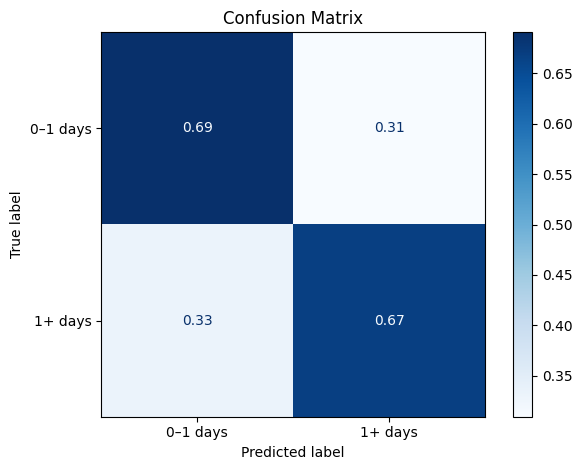

In [17]:
# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_estimator(
    pipeline,
    X_test,
    y_test_enc,
    display_labels=le.classes_,
    cmap='Blues',
    normalize='true',
)

plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Permutation Importance

In [18]:
# Top 10 most important features from original Random Forest vs improved Random Forest

# Baseline Random Forest
base_perm = permutation_importance(
    pipeline_base, Xb_test, yb_test_enc, n_repeats=10, random_state=42
)
base_importance = pd.DataFrame({
    "feature": Xb_test.columns,
    "importance_mean": base_perm.importances_mean
}).sort_values(by="importance_mean", ascending=False).head(10)

# Context Improved Random Forest Permutation Importance
perm = permutation_importance(
    pipeline, X_test, y_test_enc, n_repeats=10, random_state=42
)

importance_perm = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean
}).sort_values(by="importance_mean", ascending=False).head(10)

# Combine for comparison
comparison_df = pd.DataFrame({
    "Original Top 10 Features": base_importance["feature"].values,
    "Original Importance": base_importance["importance_mean"].values,
    "Improved Top 10 Features": importance_perm["feature"].values,
    "Improved Importance": importance_perm["importance_mean"].values
})

print("\nFeature Importance Comparison (Top 10)\n")
print(comparison_df.to_string(index=False))


Feature Importance Comparison (Top 10)

Original Top 10 Features  Original Importance Improved Top 10 Features  Improved Importance
          Vict Age Group             0.053684           Vict Age Group             0.051653
         Premis_Category             0.045759          Premis_Category             0.042573
             Crm Cd Desc             0.023696              Crm Cd Desc             0.017642
                    Hour             0.018319                     Hour             0.006213
               AREA NAME             0.010633            Time_Category             0.006093
       Vict Descent Full             0.008045                     Year             0.003744
           Time_Category             0.007368                 Part 1 2             0.001752
                    Year             0.006969        hospitals_per_zip             0.000319
               DayOfWeek             0.005337           distance_miles             0.000239
             Rpt Dist No             0.

### SHAP

# Visualizations
---

### Model & Performance Visuals

### Contextual Feature Visuals

### Fairness & Equity Evalutation Visuals